# Data Science Homework

Rendkívül élvezetes volt a feladat, és változatos problémákat vetett fel, aminek külön örültem :) Ezt köszönöm! 

A feladat megoldásához a Jupyter Notebookot választottam, mert bár Matlabban erősebb vagyok, a legjobban egy feladat megoldásával lehet elsajátítani egy új programozási nyelvet. 

A feladattal végül több, mint fél napot töltöttem, ami a python tudásomnak tudható be. A feladat értelmezésével és a megoldás megtervezésével kb. másfél órát töltöttem. Ezt követően kisebb megszakításokkal kétszer fél napot töltöttem a kódolással.

A megoldás menetét a kódban részletesen kommentáltam. Nem sikerült a számítás végére érnem, úgy gondolom az további sok időt venne igénybe, ehelyett írásban vetítettem előre a tervezett lépéseimet.

## 1. lépés 

Behívom az adatokat.

In [22]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pylab as plt

df_consH = pd.read_csv('consumption_history.csv')
df_tempH = pd.read_csv('temperature_history.csv')
df_tempFC_raw = pd.read_csv('temperature_forecast.csv', delimiter=';')

## 2. lépés

Megvizsgálom az idősorokat: kezdődátum, utolsó dátum, oszlopcímek, adatpontok mértéke (szükség van-e normalizációra)
A fogyasztás és hőmérséklet adatok terjedelmében nincsen óriási különbség ami torzíthatná a becslést, ezért normalizációt nem fogok alkalmazni.

In [2]:
# print(df_consH)
# print(df_tempH)
# print(df_tempFC_raw)
# print(df_consH.pod.unique())
# print(df_consH[df_consH.pod=='KOCSMA'])
# print(df_consH[df_consH.pod=='ELNOKI_PALOTA'])
# print(df_consH[df_consH.pod=='PICLIGYAR'])
# df_consH.describe()
# df_tempH.describe()

## 3. lépés

Megtisztítom a temperature_forecast adathalmazt.
Sorrendbe teszem az updated_at oszlop szerint, hogy adott dátumhoz a legutolsó frissítés a legfrissebb legyen. Ezután elhagyom a duplikált értékeket adott dátumra úgy, hogy csak az utolsót hagyom meg. A kapott dataframe-ből már csak a data_time és temperature adatok szükségesek, a többit elhagyom. A dátum szerint sorrendbe teszem, újraindexálom majd átnevezem az oszlopneveket.

In [23]:
# df_tempFC_raw.date_time.nunique()
df_tempFC = df_tempFC_raw.sort_values('updated_at').drop_duplicates('date_time', keep='last')
df_tempFC = df_tempFC[['date_time','temperature']]
df_tempFC = df_tempFC.sort_values('date_time')
df_tempFC.reset_index(drop=True, inplace=True)
df_tempFC.rename(columns = {'date_time':'time','temperature':'temp'}, inplace = True) 
# print(df_tempFC)

## 4. lépés 

A fogyasztás adatokat helyszín alapján szétbontom.
Innen észrevehető, hogy vannak hiányzó értékek, pl. az elnöki palota és a picligyár idősora ugyanakkor kezdődik és ugyanakkor végződik, mégsem egyezik a hosszuk. A három helyszín fogyasztás adatai így nem csak a hosszukban különbözhetnek, hanem adott köztes dátumra sem feltétlen van meg mindhárom helyszínre adatpont, a hiányzó sorok miatt.

In [24]:
## slicing consumption dataframe by location
cons_K = df_consH[df_consH.pod=='KOCSMA'] 
cons_K = cons_K.drop('pod', axis=1)
cons_K.reset_index(drop=True, inplace=True)
print('Kocsma fogyasztasa:')
print(cons_K)

cons_E = df_consH[df_consH.pod=='ELNOKI_PALOTA'] 
cons_E = cons_E.drop('pod', axis=1)
cons_E.reset_index(drop=True, inplace=True)
print('Elnoki palota fogyasztasa:')
print(cons_E)

cons_P = df_consH[df_consH.pod=='PICLIGYAR'] 
cons_P = cons_P.drop('pod', axis=1)
cons_P.reset_index(drop=True, inplace=True)
print('Picligyar fogyasztasa:')
print(cons_P)

Kocsma fogyasztasa:
                            time     kwh
0      2018-11-06 05:00:00+00:00  66.390
1      2018-11-06 06:00:00+00:00  58.670
2      2018-11-06 07:00:00+00:00  56.410
3      2018-11-06 08:00:00+00:00  54.270
4      2018-11-06 09:00:00+00:00  50.940
...                          ...     ...
16965  2020-10-23 23:00:00+00:00  41.103
16966  2020-10-24 00:00:00+00:00  39.992
16967  2020-10-24 01:00:00+00:00  39.992
16968  2020-10-24 02:00:00+00:00  41.103
16969  2020-10-24 03:00:00+00:00  39.992

[16970 rows x 2 columns]
Elnoki palota fogyasztasa:
                           time     kwh
0     2019-10-01 04:00:00+00:00   0.537
1     2019-10-01 05:00:00+00:00   0.000
2     2019-10-01 06:00:00+00:00   0.000
3     2019-10-01 07:00:00+00:00   0.000
4     2019-10-01 08:00:00+00:00   0.000
...                         ...     ...
9330  2020-10-23 23:00:00+00:00   4.193
9331  2020-10-24 00:00:00+00:00   4.193
9332  2020-10-24 01:00:00+00:00   5.268
9333  2020-10-24 02:00:00+00:00   5

## 5. lépés

Összefésülom a fogyasztás adatokat, hogy mindegyik egy közös dátum vektorra legyen felírva, a hiányzó adatpontok NaN-nal vannak feltöltve, semmilyen adat nem vész el az összefésülés során.
Az előző outputtal ellenőrizhető a fogyasztási adatok eleje és vége. 

In [25]:
Cons_ALL = [cons_K,cons_E,cons_P]
Cons_merged = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='outer'), Cons_ALL)
Cons_merged.rename(columns = {'kwh_x':'kwh_K','kwh_y':'kwh_E','kwh':'kwh_P'}, inplace = True)
Cons_merged = Cons_merged.sort_values('time')
print(Cons_merged)

                            time   kwh_K   kwh_E  kwh_P
0      2018-11-06 05:00:00+00:00  66.390     NaN    NaN
1      2018-11-06 06:00:00+00:00  58.670     NaN    NaN
2      2018-11-06 07:00:00+00:00  56.410     NaN    NaN
3      2018-11-06 08:00:00+00:00  54.270     NaN    NaN
4      2018-11-06 09:00:00+00:00  50.940     NaN    NaN
...                          ...     ...     ...    ...
16965  2020-10-23 23:00:00+00:00  41.103   4.193   42.0
16966  2020-10-24 00:00:00+00:00  39.992   4.193    9.0
16967  2020-10-24 01:00:00+00:00  39.992   5.268   20.0
16968  2020-10-24 02:00:00+00:00  41.103   5.268   11.0
16969  2020-10-24 03:00:00+00:00  39.992  21.289   10.0

[17087 rows x 4 columns]


## 6. lépés 

A temperature_history adatokat is hozzáfésülöm a fogyasztás adatokhoz.

2018/11/06 előtt nincs fogyasztás adat, csak hőmérséklet adat, a múltbeli hőmérsékletet a jelenbeli fogyasztás becsléséhez nem lehetne felhasználni, ha lenne hőmérséklet hiányzó adat, azt lehetne becsülni belőle, de erre most nincs szükség. A hőmérséklet adatokat ezért ugyanarra az időintervallumra fűzöm a fogyasztás adatok mellé. Jól látható, hogy a dataframe kibővült új sorokkal, tehát voltak hiányzó értékek a fogyasztás dataframe-ben (minden helyszínen hiányzott), amikre hőmérséklet adat viszont elérhető. Ezekben a sorokban a fogyasztások NaN-nal szerepelnek.

Kérdés, hogyha nincs fogyasztás adat adott órára sehonnan de hőmérséklet van, tartsuk-e meg a sort? Úgy döntöttem megtartom, mivel most nincs szakadás a dataframe-ben: ha napi átlagot veszek és hiányzik egy óra fogyasztás, a hőmérséklet pontosan kiszámítható napi átlagban (nem veszítünk információt), a fogyasztás esetében pedig az adatokból elérhető legjobb becslést kapjuk a napi átlagra, a hiányzó adatpontok mellett is.

In [26]:
df_tempH = df_tempH[df_tempH['time']>=Cons_merged.time.min()]
df_tempH['time'] = pd.to_datetime(df_tempH.time)
Cons_merged['time'] = pd.to_datetime(Cons_merged.time)

merged_data = pd.merge(Cons_merged,df_tempH, how='outer', on='time')
merged_data = merged_data.sort_values('time')
merged_data.reset_index(drop=True, inplace=True)
print(merged_data)

                           time   kwh_K   kwh_E  kwh_P   temp
0     2018-11-06 05:00:00+00:00  66.390     NaN    NaN   6.33
1     2018-11-06 06:00:00+00:00  58.670     NaN    NaN   6.33
2     2018-11-06 07:00:00+00:00  56.410     NaN    NaN   8.34
3     2018-11-06 08:00:00+00:00  54.270     NaN    NaN  10.33
4     2018-11-06 09:00:00+00:00  50.940     NaN    NaN  11.33
...                         ...     ...     ...    ...    ...
17226 2020-10-23 23:00:00+00:00  41.103   4.193   42.0  10.41
17227 2020-10-24 00:00:00+00:00  39.992   4.193    9.0  10.46
17228 2020-10-24 01:00:00+00:00  39.992   5.268   20.0  10.22
17229 2020-10-24 02:00:00+00:00  41.103   5.268   11.0   9.81
17230 2020-10-24 03:00:00+00:00  39.992  21.289   10.0   9.66

[17231 rows x 5 columns]


## 7. lépés 

Scatter ploton ábrázolom a becslés változóit, a hőmérséklet-fogyasztás kapcsolatot mindhárom helyszínen.
A kocsma helyszínen szemmel látható negatív kapcsolat van a fogyasztás és hőmérséklet adatok között (nő a hőmérséklet, kevesebbet fűtenek), míg az elnöki palota esetében gyengébb, a picligyár esetében semmilyen kapcsolat nincs.

A picligyár valószínűleg a gázt nem fűtésre használja, hanem a gyártási folyamatokhoz, a piclit pedig időjárástól függetlenül mindig gyártani kell :) Tehát a picligyár esetében nem annyira a hőmérséklettel, mint inkább a gyártás hasonló időszaki fogyasztásával lehet megbecsülni a mai fogyasztást.

Elnöki palotánál a hőmérséklet és a múltbeli fogyasztás is kellhet a becsléshez.

Múltbeli fogyasztásból érdekes lehet az egy órával azelőtti, az egy nappal azelőtti és az egy héttel korábbi (ha a hét napjain különböző munkarend van).

Text(0.5, 1.0, 'PICLIGYAR')

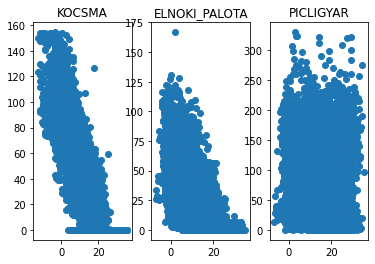

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(merged_data.temp,merged_data.kwh_K)
ax2.scatter(merged_data.temp,merged_data.kwh_E)
ax3.scatter(merged_data.temp,merged_data.kwh_P)

ax1.set_title(df_consH.pod.unique()[0])
ax2.set_title(df_consH.pod.unique()[1])
ax3.set_title(df_consH.pod.unique()[2])

## 8. lépés 

Megvizsgálom a fogyasztás késleltettjeinek a mai adatokra való hatását.
Most jön jól, hogy nincs szakadás a dataframe-ben: a 24. késleltetett pont a 24. órával ezelőtti adat.
1 és 24 órával, 1 héttel és (kíváncsiságból) 2 héttel korábbi fogyasztás értékek és a mai kapcsolata:

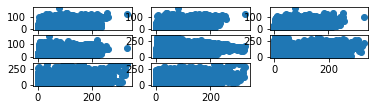

In [28]:
for i in (1, 24, 168,336):
    merged_data['kwh_E_lag' + str(i)] = merged_data['kwh_E'].shift(i)
    merged_data['kwh_P_lag' + str(i)] = merged_data['kwh_P'].shift(i)

fig = plt.figure()
ax1 = fig.add_subplot(831)
ax2 = fig.add_subplot(832)
ax3 = fig.add_subplot(833)
ax4 = fig.add_subplot(834)

ax1.scatter(merged_data.kwh_E_lag1,merged_data.kwh_E)
ax2.scatter(merged_data.kwh_E_lag24,merged_data.kwh_E)
ax3.scatter(merged_data.kwh_E_lag168,merged_data.kwh_E)
ax4.scatter(merged_data.kwh_E_lag336,merged_data.kwh_E)

ax5 = fig.add_subplot(835)
ax6 = fig.add_subplot(836)
ax7 = fig.add_subplot(837)
ax8 = fig.add_subplot(838)

ax5.scatter(merged_data.kwh_P_lag1,merged_data.kwh_P)
ax6.scatter(merged_data.kwh_P_lag24,merged_data.kwh_P)
ax7.scatter(merged_data.kwh_P_lag168,merged_data.kwh_P)
ax8.scatter(merged_data.kwh_P_lag336,merged_data.kwh_P)


Még mindig semmi korreláció nem látszódik. 

A picligyár fogyasztás adatait érdemes megbontani szint, trend és szezonalitás komponensekre, a maradék pedig a zaj. De mindenekelőtt napi frekvenciára hozom az adatokat, ami a nomináláshoz hasznos lesz. 

In [29]:
merged_data = merged_data[['time','kwh_K','kwh_E','kwh_P','temp']]
merged_data.set_index('time', inplace=True)

In [36]:
merged_data_daily = merged_data.resample('D').agg({'kwh_K': np.sum,'kwh_E': np.sum,'kwh_P': np.sum, 'temp': np.mean})

## 9. lépés: a Picligyár előrejelzésének megtervezése

Additív dekompozíciót használok a picligyár fogyasztására:

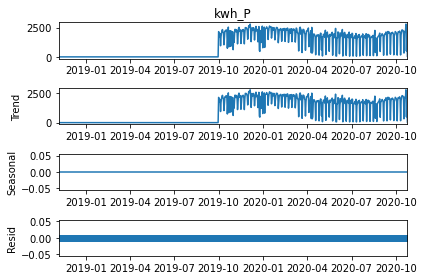

In [38]:
## Source: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(merged_data_daily.kwh_P, model='additive', period=1)
result.plot()
pyplot.show()

Jól látható, hogy az additív dekomp nem tudta megkülönböztetni a zajt a trendtől... Más filterezésre lesz szükség. Nézzük meg multiplikatív dekomppal:

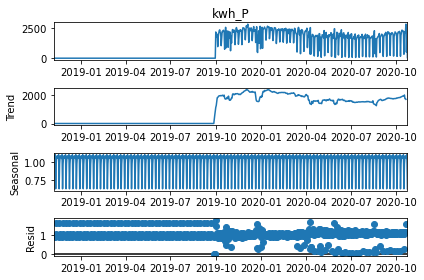

In [41]:
## Source: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# A multiplikatív dekomp nem alkalmas 0 értékeket tartalmazó idősor dekompjára, ideiglenesen ezért hozzáadok 1-et, majd a végén levonom.
TempData = merged_data_daily.kwh_P + 1
result = seasonal_decompose(TempData, model='multiplicative')
result.plot()
pyplot.show()

A multiplikatív dekomppal meghatározható egy (nem kifejezetten szép) trend és egy szezonalitás komponens, ebből előrejelzés úgy készíthető, hogy a trendet kivetítjük a következő periódusra (pl. egy polinom ráillesztésével) és ráadjuk a megfelelő szezonalitás mértéket.

## 10. lépés: a Kocsma előrejelzésének megtervezése

A másik helyszín, aminél a korreláció utal egy adott előrejelzési módszerre, az a kocsma esete. A kocsma fogyasztási adatai és a hőmérséklet múltbeli adatok szembetűnő korrelációt mutatnak. Az előrejelzést egy lineáris regresszióval végezném, ahol a cél változó a fogyasztás, a magyarázó változó pedig a hőmérséklet (+ a fogyasztás lagje, ha kell). 

A regressziós paraméterek becslését a gradient descent módszerrel oldanám meg: először meghatároznék egy cost functiont, ami tükrözi a hiba és a büntetés minimalizálásának együttes célját.

## Nominálás számításnál:

y = gáznapi fogyasztás

x = gáznapi átlag hőmérséklet

Cost function:

1/2m * (becsült y - y)^2 + lambda * dummy * abs(becsült y - y)

    ahol az 1/2m a cost function definiálásának megszokott módja szerint egy skálázó konstans, ami megkönnyíti a deriválás utáni eredmény felírását

    a lambda egy arányossági paraméter, ami a büntetést meghatározza

    a dummy akkor ad 1-et, ha a becsült y 14%-nál nagyobb mértékben tér el a tény y-tól


Ennek a cost functionnek a deriváltja a regressziós paraméterek szerint ( = Gradiens):

1/m * X^T * (X * Theta - y) + lambda * dummy * X

A gradient descent módszer pedig egy iterációs folyamat, ahol a paraméterhalmazt igazítjuk a gradiens vektor (cost function deriváltja) és egy alpha lépték szorzatával:

theta(i) = theta(i) + alpha * Gradiens(i)

Itt az alphat érdemes elsőként 1-nek venni, majd ha lassan konvergál be a folyamat lehet növelni, ha pedig folyton átugorja az optimumot, akkor csökkenteni.



## A kapacitás lekötésnél hasonlóan járnék el:

y = gáznapi max kapacitás

x = gáznapi minimum hőmérséklet

Cost function:

1/2m * (becsült y - y)^2 + c * becsült y + 4 * c * (y - becsült y)

### Ha mind a nominálás, mind a kapacitás-lekötés esetén fellépő büntetést egyszerre akarjuk minimalizálni, a cost function egyszerűen bővíthető új taggal a fentiek szerint. Ez azért is lehet előnyös, mert nem ismerjük a büntetések arányosító paramétereit (lambda és c), tehát ha tegyük fel a kapacitás túllépést kiugróan magas büntetés követi, akkor a módszer jobban fog optimalizálni annak a hibaszámításnak a csökkentésére. Ilyen módon súlyozni tudjuk a költségfüggvényt: nagy c esetén a módszer olyan becslést fog adni, hogy a kapacitás-lekötést leginkább soha ne lépjük túl.

## 11. lépés:

Az elnöki palotánál a két helyszín megoldásának kombinációját látom valószínűnek, azaz magyarázó változóként mindenképp szükséges lesz a hőmérséklet mellett egy fogyasztás késleltetett jelenléte is. Lineáris regresszióval felírva, több magyarázó változóra is működik a gradient descent módszer, a két számítási módszernek megfelelő költségfüggvények felírásával.

## 12. lépés

A három helyszín fogyasztásának összeadása a szombati és vasárnapi napon, a két gázfogyasztási módszerre külön-külön.